In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

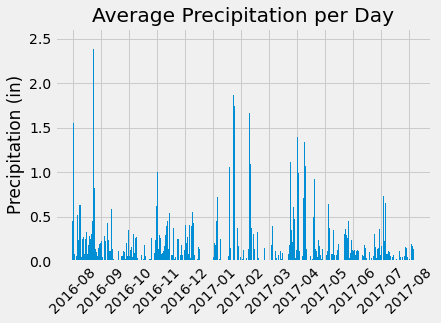

In [10]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
analysis_end = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
analysis_start = (dt.datetime.strptime(analysis_end, "%Y-%m-%d").date() - dt.timedelta(days=365)).strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation score and 
# save the results as a Pandas DataFrame
results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                  filter(Measurement.date >= analysis_start).\
                  group_by(Measurement.date).\
                  order_by(Measurement.date).all()

df = pd.DataFrame(results, columns=["Date", "Precipitation"])

labels = ["2016-08", "2016-09", "2016-10", "2016-11", "2016-12", "2017-01",
          "2017-02", "2017-03", "2017-04", "2017-05", "2017-06", "2017-07", "2017-08"]
locations = [30*i for i in np.arange(len(labels))]

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(np.arange(len(df.index)), df["Precipitation"], width=1.1)
plt.xticks(locations, labels, rotation=45)
plt.ylim(0, max(df["Precipitation"])+max(df["Precipitation"])*0.1)
plt.ylabel("Precipitation (in)")
plt.title("Average Precipitation per Day")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [12]:
# Design a query to show how many stations are available in this dataset?
num_stations = (session.query(Measurement.station).distinct()).count()
num_stations

9

In [13]:
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

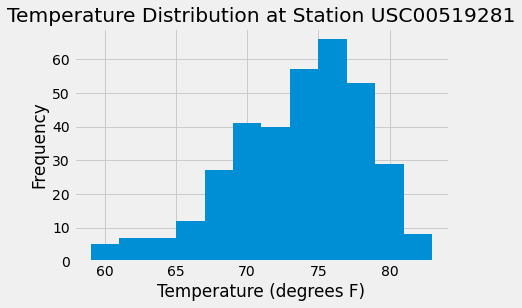

In [15]:
# Query the last 12 months of temperature observation data for the most active station and plot the results as a histogram
recent_temp_most_pop_station = list(np.ravel(session.query(Measurement.tobs).\
    filter(Measurement.station=='USC00519281').\
    filter(Measurement.date>=analysis_start).\
    order_by(Measurement.date).all()))

plt.hist(recent_temp_most_pop_station, bins=12)
plt.xlabel("Temperature (degrees F)")
plt.ylabel("Frequency")
plt.title("Temperature Distribution at Station USC00519281")
plt.show()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_start = '2017-06-20'
my_end = '2017-06-25'
my_trip = calc_temps(my_start, my_end)

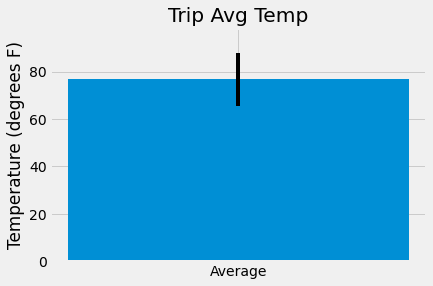

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar("Average", my_trip[0][1], yerr=my_trip[0][2]-my_trip[0][0])
plt.ylim(0, my_trip[0][2]*(1.2))
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (degrees F)")
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rainfall = session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
                                filter(Measurement.date>=my_start).\
                                filter(Measurement.date<=my_end).\
                                group_by(Station.station).\
                                order_by(func.sum(Measurement.prcp).desc()).all()
total_rainfall

[(3.4100000000000006,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 (3.4100000000000006,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 (3.4100000000000006,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 (3.4100000000000006,
  'USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6),
 (3.4100000000000006,
  'USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9),
 (3.4100000000000006,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 (3.4100000000000006,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 (3.4100000000000006,
  'USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 (3.4100000000000006,
  'USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9)]

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# Use the start and end date to create a range of dates
my_start = '2017-06-20'
my_end = '2017-06-25'
trip_length = (dt.datetime.strptime(my_end, "%Y-%m-%d") - dt.datetime.strptime(my_start, "%Y-%m-%d")).days

# Strip off the year and save a list of %m-%d strings
my_trip_dates = [dt.datetime.strftime((dt.datetime.strptime(my_start, "%Y-%m-%d")+dt.timedelta(days=x)), "%m-%d") for x in range(trip_length+1)]

# Loop through the list of %m-%d strings and calculate the normals for each date

normals = [(trip_date, daily_normals(trip_date)[0][0], daily_normals(trip_date)[0][1], daily_normals(trip_date)[0][2]) for trip_date in my_trip_dates]

normals

[('06-20', 68.0, 73.96491228070175, 85.0),
 ('06-21', 68.0, 74.75862068965517, 82.0),
 ('06-22', 69.0, 75.15789473684211, 81.0),
 ('06-23', 68.0, 74.54385964912281, 80.0),
 ('06-24', 68.0, 74.96428571428571, 84.0),
 ('06-25', 68.0, 74.10344827586206, 80.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=["trip_dates", "tmin", "tavg", "tmax"])
normals_df

,trip_dates,tmin,tavg,tmax
0,06-20,68.0,73.964912,85.0
1,06-21,68.0,74.758621,82.0
2,06-22,69.0,75.157895,81.0
3,06-23,68.0,74.543860,80.0
4,06-24,68.0,74.964286,84.0
5,06-25,68.0,74.103448,80.0


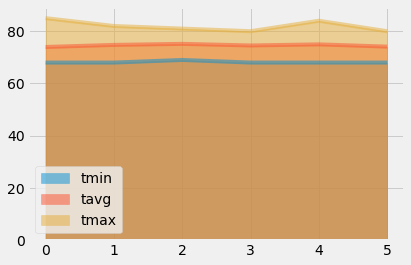

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)